# Лабораторная работа 3
### Выполнил: ФИО

Добро пожаловать в третью лабораторную работу!
Оформите ваше решение контеста Kaggle в соответствии с этим шаблоном. Ваша задача - показать проверяющим ход ваших рассуждений, поэтому советуем писать много комментариев к коду и приводить комментарии к логике на каждом этапе в текстовых ячейках.
Где необходимо, используйте графики для большей наглядности.

При отправке поменяйте название файла на ваши ФИО!

### Настройка Google Colab

Подключение вашего гугл диска (советуем сохранять все важные артефакты именно на диск, чтобы они не удалились при закрытии вкладки с ноутбуком).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Если вы используете google colab и загрузка датасета занимает больше минуты - раскомментируйте и выполните эту ячейку.

In [ ]:
# import json
# import os

# def download_contest3_data():
#   # !mkdir ~/.kaggle # закоментить если ругается
#   # !touch ~/.kaggle/kaggle.json # закоментить если ругается

#   # токен надо сгенерировать в личном кабинете на kaggle (https://www.kaggle.com/settings/account)
#   api_token = {"username":"fokuspokus","key":"abrakadabra"}
#   with open('/root/.kaggle/kaggle.json', 'w') as file:
#       json.dump(api_token, file)

#   !chmod 600 ~/.kaggle/kaggle.json

#   !kaggle competitions download -p /content/drive/MyDrive/ -c ml-mipt-2023-contest-3

#   if not os.path.isdir("/content/drive/MyDrive/contest3"):
#     !mkdir /content/drive/MyDrive/contest3

#   !unzip /content/drive/MyDrive/ml-mipt-2023-contest-3.zip -d /content/drive/MyDrive/contest3

# download_contest3_data()

In [ ]:
!cp -r /content/drive/MyDrive/contest3 /content/contest3

### EDA (исследовательский анализ данных)

В этой лабораторной вы работаете с картинками. Напишите функцию, которая отрисовывала бы ключевые точки на конкретном изображении, это вам пригодится для дебага.
Можете посчитать статистики по картинкам в датасете.

Подключение библиотек:

In [ ]:
import numpy as np
import os
import cv2
import random
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn

Фиксирование seed:

In [ ]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

Рассмотрим данные:

In [ ]:
TRAIN_PATH = "contest3/train_labels.csv"
IMAGE_TRAIN_PATH = "contest3/images/train"
IMAGE_TEST_PATH = "contest3/images/test"
TARGET_SIZE = 224
train_data = pd.read_csv(TRAIN_PATH)
train_data.head()

,left_eye_x,left_eye_y,right_eye_x,right_eye_y,mouth_x,mouth_y,left_ear_1_x,left_ear_1_y,left_ear_2_x,left_ear_2_y,left_ear_3_x,left_ear_3_y,right_ear_1_x,right_ear_1_y,right_ear_2_x,right_ear_2_y,right_ear_3_x,right_ear_3_y,file_name
0,177.0,124.0,240.0,146.0,208.0,172.0,132.0,97.0,149.0,30.0,190.0,81.0,245.0,102.0,304.0,95.0,268.0,145.0,b4735fa043136534973c17fca358aee9.jpg
1,90.0,231.0,169.0,220.0,134.0,287.0,55.0,202.0,33.0,129.0,77.0,164.0,155.0,153.0,199.0,101.0,207.0,180.0,8d8a9448a43e70077784825b26433d6d.jpg
2,254.0,160.0,340.0,174.0,286.0,245.0,207.0,126.0,207.0,14.0,274.0,94.0,336.0,103.0,422.0,50.0,384.0,155.0,274977dfe9d5cceb1e0a3bb57088164b.jpg
3,559.0,309.0,729.0,353.0,631.0,390.0,470.0,239.0,479.0,87.0,572.0,205.0,756.0,248.0,896.0,188.0,837.0,335.0,dfcd37f5dba0df53a2656b46b8aeb7f4.jpg
4,143.0,159.0,229.0,145.0,186.0,226.0,108.0,121.0,71.0,34.0,141.0,74.0,230.0,59.0,287.0,3.0,290.0,89.0,9ae060a543c60e4dc9d3539cfbc8fb79.jpg


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8997 entries, 0 to 8996
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   left_eye_x     8997 non-null   float64
 1   left_eye_y     8997 non-null   float64
 2   right_eye_x    8997 non-null   float64
 3   right_eye_y    8997 non-null   float64
 4   mouth_x        8997 non-null   float64
 5   mouth_y        8997 non-null   float64
 6   left_ear_1_x   8997 non-null   float64
 7   left_ear_1_y   8997 non-null   float64
 8   left_ear_2_x   8997 non-null   float64
 9   left_ear_2_y   8997 non-null   float64
 10  left_ear_3_x   8997 non-null   float64
 11  left_ear_3_y   8997 non-null   float64
 12  right_ear_1_x  8997 non-null   float64
 13  right_ear_1_y  8997 non-null   float64
 14  right_ear_2_x  8997 non-null   float64
 15  right_ear_2_y  8997 non-null   float64
 16  right_ear_3_x  8997 non-null   float64
 17  right_ear_3_y  8997 non-null   float64
 18  file_nam

In [ ]:
keypoints = train_data.columns[:-1]
keypoints

Index(['left_eye_x', 'left_eye_y', 'right_eye_x', 'right_eye_y', 'mouth_x',
       'mouth_y', 'left_ear_1_x', 'left_ear_1_y', 'left_ear_2_x',
       'left_ear_2_y', 'left_ear_3_x', 'left_ear_3_y', 'right_ear_1_x',
       'right_ear_1_y', 'right_ear_2_x', 'right_ear_2_y', 'right_ear_3_x',
       'right_ear_3_y'],
      dtype='object')

Подберём разные цвета для точек:

In [ ]:
DEFAULT_POINT_COLORS = [
    (255, 0, 0), (150, 0, 0), (255, 0, 255),
    (150, 255, 0), (0, 255, 0), (0, 150, 0),
    (0, 255, 255), (0, 150, 255), (0, 0, 255)
]

Функция отрисовки:

In [ ]:
def draw_keypoints_on_image(img, keypoints, radius=5, point_colors=DEFAULT_POINT_COLORS):
    """
    Рисует ключевые точки на уже загруженном RGB изображении (img)
    Возвращает изменённое изображение
    """
    img_copy = img.copy()
    for i in range(0, len(keypoints), 2):
        x = int(keypoints[i])
        y = int(keypoints[i + 1])
        color = point_colors[i//2]
        cv2.circle(img_copy, (x, y), radius, color, -1)
    return img_copy

In [ ]:
def draw_keypoints(image_path, keypoints, ax, radius=5, point_colors=DEFAULT_POINT_COLORS):
    """
    image_path: путь к картинке
    keypoints: массив ключевых точек (18,) [x1, y1, x2, y2, ...]
    """
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = draw_keypoints_on_image(img, keypoints, radius, point_colors)
    ax.imshow(img)
    ax.axis("off")

Пример изображений:

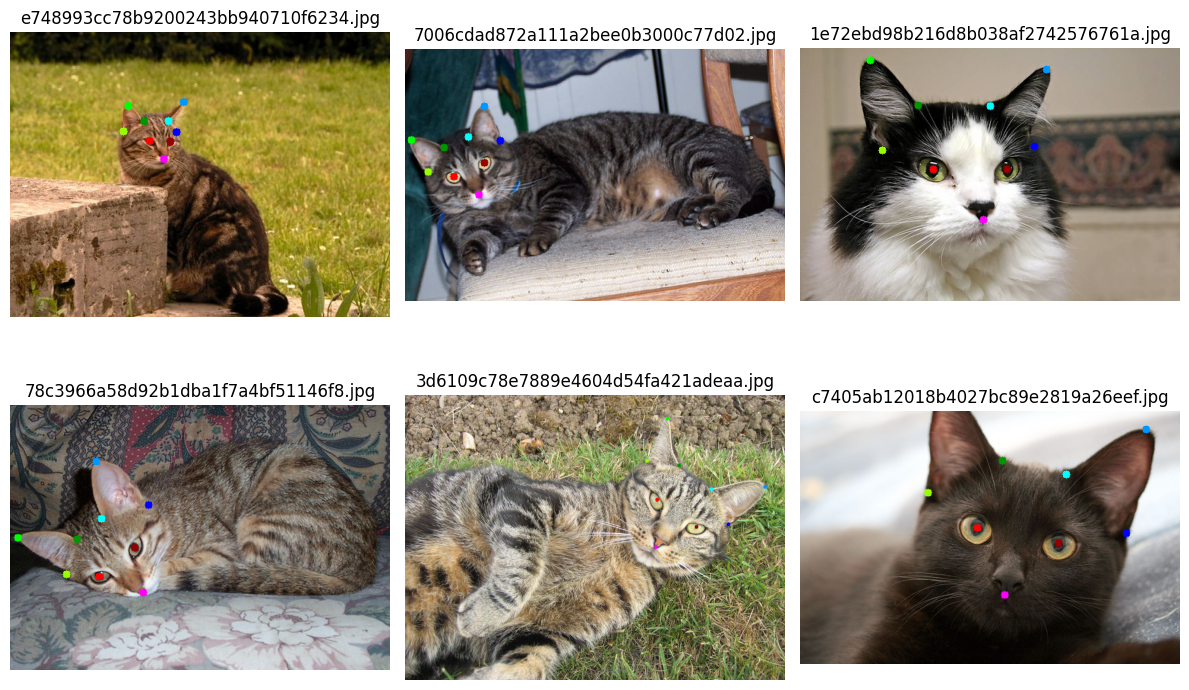

In [ ]:
sample_rows = train_data.sample(6, random_state=seed)
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
for ax, (_, row) in zip(axes.flatten(), sample_rows.iterrows()):
    file_name = row["file_name"]
    image_path = os.path.join(IMAGE_TRAIN_PATH, file_name)
    kp = row[keypoints].to_numpy()
    draw_keypoints(image_path, kp, ax)
    ax.set_title(file_name)
plt.tight_layout()
plt.show()

Количество изображений и количество полей различны, проверим уникальность file_name:

In [ ]:
train_data['file_name'].is_unique

False

Выведем строки с неуникальными значениями filename:

In [ ]:
duplicates = train_data[train_data.duplicated(subset='file_name', keep=False)]
duplicates

,left_eye_x,left_eye_y,right_eye_x,right_eye_y,mouth_x,mouth_y,left_ear_1_x,left_ear_1_y,left_ear_2_x,left_ear_2_y,left_ear_3_x,left_ear_3_y,right_ear_1_x,right_ear_1_y,right_ear_2_x,right_ear_2_y,right_ear_3_x,right_ear_3_y,file_name
140,204.0,158.0,271.0,159.0,230.0,201.0,172.0,143.0,154.0,70.0,208.0,110.0,281.0,110.0,336.0,65.0,326.0,145.0,7d3cdffd19b9cec0d44661797492b94a.jpg
448,406.0,330.0,609.0,358.0,486.0,485.0,305.0,259.0,237.0,37.0,385.0,202.0,655.0,241.0,810.0,124.0,733.0,320.0,e4f6e24a432559c091e0292b12024466.jpg
1649,628.0,366.0,727.0,376.0,671.0,456.0,556.0,275.0,566.0,160.0,642.0,242.0,740.0,249.0,831.0,181.0,813.0,294.0,7d3cdffd19b9cec0d44661797492b94a.jpg
1968,207.0,216.0,292.0,219.0,246.0,292.0,155.0,167.0,153.0,65.0,216.0,136.0,292.0,137.0,366.0,81.0,348.0,179.0,e4f6e24a432559c091e0292b12024466.jpg


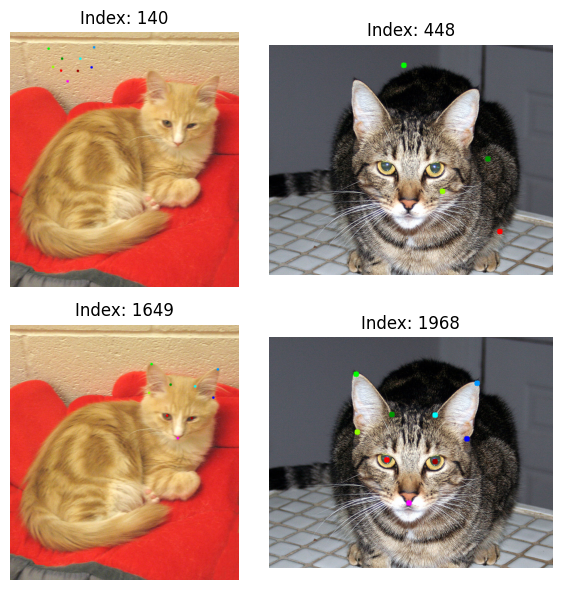

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(6, 6))
for ax, (_, row) in zip(axes.flatten(), duplicates.iterrows()):
    file_name = row["file_name"]
    image_path = os.path.join(IMAGE_TRAIN_PATH, file_name)
    kp = row[keypoints].to_numpy()
    draw_keypoints(image_path, kp, ax)
    ax.set_title(f"Index: {row.name}")
plt.tight_layout()
plt.show()

In [ ]:
train_data = train_data.drop(index=[140, 448]).reset_index(drop=True)
train_data['file_name'].is_unique

True

Статистика датасета:

In [ ]:
train_data[keypoints].describe()

,left_eye_x,left_eye_y,right_eye_x,right_eye_y,mouth_x,mouth_y,left_ear_1_x,left_ear_1_y,left_ear_2_x,left_ear_2_y,left_ear_3_x,left_ear_3_y,right_ear_1_x,right_ear_1_y,right_ear_2_x,right_ear_2_y,right_ear_3_x,right_ear_3_y
count,8995.000000,8995.000000,8995.000000,8995.000000,8995.000000,8995.000000,8995.000000,8995.000000,8995.000000,8995.000000,8995.000000,8995.000000,8995.000000,8995.000000,8995.000000,8995.000000,8995.000000,8995.000000
mean,264.128627,213.909616,342.221456,213.795775,303.452251,274.302057,213.546637,177.712840,203.816676,91.031351,264.047582,139.448916,340.636465,140.357087,401.174764,90.864369,390.806893,179.412007
std,136.700280,104.323760,157.641467,103.917261,146.596731,131.407011,133.038773,96.822073,143.735649,94.119821,141.647949,86.325679,161.149373,85.809637,190.404794,92.546890,177.523752,96.233545
min,29.000000,19.000000,55.000000,22.000000,32.000000,55.000000,-44.000000,-37.000000,-188.000000,-214.000000,24.000000,-96.000000,37.000000,-106.000000,0.000000,-235.000000,59.000000,-61.000000
25%,172.000000,142.000000,236.000000,142.000000,205.000000,183.000000,122.000000,112.000000,106.000000,32.000000,167.000000,82.000000,232.000000,83.000000,275.000000,33.000000,271.000000,115.000000
50%,226.000000,183.000000,295.000000,183.000000,261.000000,236.000000,181.000000,151.000000,172.000000,69.000000,227.000000,117.000000,295.000000,119.000000,351.000000,71.000000,340.000000,153.000000
75%,320.000000,260.000000,402.000000,260.000000,360.000000,331.000000,268.000000,219.000000,264.000000,125.000000,321.000000,173.500000,402.000000,175.000000,469.000000,125.000000,450.000000,219.000000
max,902.000000,786.000000,952.000000,783.000000,976.000000,876.000000,897.000000,844.000000,1063.000000,894.000000,922.000000,827.000000,968.000000,828.000000,1156.000000,935.000000,1011.000000,778.000000


Анализ размеров изображений:

In [ ]:
heights = []
widths = []
for filename in train_data["file_name"]:
    img = cv2.imread(os.path.join(IMAGE_TRAIN_PATH, filename))
    h, w, _ = img.shape
    heights.append(h)
    widths.append(w)

print("Height:\nmin:", min(heights), " max:", max(heights))
print("Width:\nmin:", min(widths), " max:", max(widths))

Height:
min: 101  max: 1024
Width:
min: 135  max: 1024


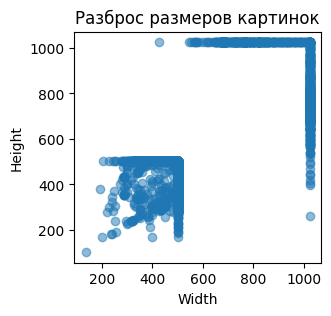

In [ ]:
plt.figure(figsize=(7, 3))
plt.subplot(1, 2, 1)
plt.scatter(widths, heights, alpha=0.5)
plt.xlabel("Width")
plt.ylabel("Height")
plt.title("Разброс размеров картинок")
plt.show()

Точки за пределами изображений:

In [ ]:
images = []
for idx, row in train_data.iterrows():
    filename = row["file_name"]
    image_path = os.path.join(IMAGE_TRAIN_PATH, filename)
    h, w, _ = cv2.imread(image_path).shape
    out_of_bounds = False
    for i in range(0, len(keypoints), 2):
        x = row[keypoints[i]]
        y = row[keypoints[i + 1]]
        if x < 0 or y < 0 or x >= w or y >= h:
            out_of_bounds = True
            break

    if out_of_bounds:
        images.append(filename)

print(f"Всего картинок с точками за пределами изображения: {len(images)}")

Всего картинок с точками за пределами изображения: 964


Выводы:
- Некоторые точки выходят за границу изображения.
- Изображения имеют разный размер. Прямой resize к квадратному формату может искажать пропорции, поэтому на этапе препроцессинга необходимо использовать padding с сохранением соотношений сторон.
- Большой разброс котов.

### Preprocessing (подготовка данных)

Мы ожидаем, что в этом разделе вы реализуете кастомный класс для подгрузки данных (cоветуем унаследоваться от `torch.utils.data.Dataset`).

In [ ]:
# КОСЯКИ.  сделал 2 варианта с препроцессом и без, препроцесс вроде ускорил

In [ ]:
def prepare_images(df, src_dir, out_dir, keypoints_cols, target_size=224):
    os.makedirs(out_dir, exist_ok=True)
    is_train = df is not None

    if is_train:
        new_df = df.copy()
        filenames = new_df["file_name"].values
    else:
        filenames = sorted([f for f in os.listdir(src_dir) if f.endswith('.jpg')])

    for filename in tqdm(filenames):
        img_path = os.path.join(src_dir, filename)
        img = cv2.imread(img_path)
        if img is None:
            print(f"Propblem with {filename}")
            continue

        h, w = img.shape[:2]
        scale = target_size / max(h, w)
        nw, nh = int(w * scale), int(h * scale)

        # Ресайз и паддинг
        img_res = cv2.resize(img, (nw, nh), interpolation=cv2.INTER_AREA)
        canvas = np.zeros((target_size, target_size, 3), dtype=np.uint8)
        pad_x, pad_y = (target_size - nw) // 2, (target_size - nh) // 2
        canvas[pad_y:pad_y+nh, pad_x:pad_x+nw] = img_res

        cv2.imwrite(os.path.join(out_dir, filename), canvas)

        if is_train:
            idx = new_df[new_df["file_name"] == filename].index[0]
            pts = new_df.loc[idx, keypoints_cols].values.astype(np.float32)
            pts[0::2] = (pts[0::2] * scale + pad_x) / target_size
            pts[1::2] = (pts[1::2] * scale + pad_y) / target_size
            new_df.loc[idx, keypoints_cols] = pts

    return new_df if is_train else None

In [ ]:
train_data224 = prepare_images(train_data, IMAGE_TRAIN_PATH, "contest3/train224", keypoints)
prepare_images(None, IMAGE_TEST_PATH, "contest3/test224", keypoints)

  0%|          | 0/8995 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
class CatDataset(Dataset):
    def __init__(self, image_dir, data=None, transform=None):
        """
        image_dir: путь к папке с картинками 224x224
        data: DataFrame, точки под 224x224
        """
        self.image_dir = image_dir
        self.transform = transform
        self.is_train = data is not None
        if self.is_train:
            self.filenames = data["file_name"].values
            self.points = data.drop(columns=["file_name"]).values.astype(np.float32)
        else:
            self.filenames = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])

    def __len__(self) -> int:
        return len(self.filenames)

    def __getitem__(self, idx: int):
        file_name = self.filenames[idx]
        img_path = os.path.join(self.image_dir, file_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.transpose(2, 0, 1).astype(np.float32) / 255.0
        img = torch.from_numpy(img)

        if self.transform:
            img = self.transform(img)

        if not self.is_train:
            return img, file_name
        return img, torch.from_numpy(self.points[idx])

In [ ]:
train_df, val_df = train_test_split(
    train_data224,
    test_size=0.2,
    random_state=seed
)
datasets = {
    'train': CatDataset("contest3/train224", data=train_df),
    'val': CatDataset("contest3/train224", data=val_df),
    'test': CatDataset("contest3/test224")
}

Проверим работу датасета:

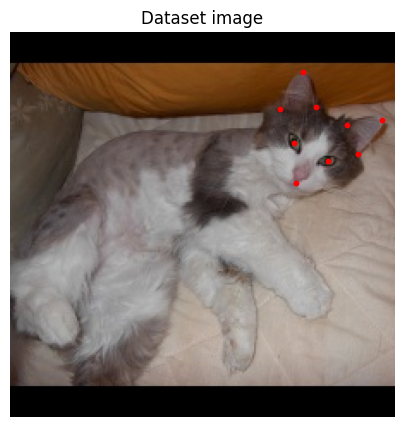

In [ ]:
img, points = datasets['train'][0]
img_np = img.permute(1, 2, 0).numpy()
points = points.numpy() * TARGET_SIZE

plt.figure(figsize=(5,5))
plt.imshow(img_np)
for i in range(0, len(points), 2):
    plt.scatter(points[i], points[i+1], c='r', s=10)
plt.title("Dataset image")
plt.axis("off")
plt.show()


### Training/evaluation loop

В этом разделе напишите функцию, принимающую модель, оптимизатор, кол-во эпох, и т.д, которая осуществляет обучение с заданными параметрами. Подумайте, что функция будет возвращать.

Смысл этого раздела в том, чтобы не дублировать код обучения для каждого эксперимента. А еще на такую функцию легко накинуть перебор гиперпараметров...

In [ ]:
def train_model(model, dataloaders, optimizer, num_epochs,
                criterion, device, patience_early_stop=5, path="best_model.pth"):
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_mae': [],
        'val_mae': []
    }
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
        mode='min', factor=0.5, patience=5)
    best_val_loss = float('inf')
    early_stop_counter = 0
    model.to(device)
    for epoch in range(num_epochs):
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # train
            else:
                model.eval()  # validation
            run_loss = 0.0
            run_mae = 0.0
            # Итерация по батчам
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                # Вычисление градиентов происходит только при обучении
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    mae = torch.abs(outputs - labels).mean()
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                run_loss += loss.item() * inputs.size(0)
                run_mae += mae.item() * inputs.size(0)
            # Вычисление средней ошибки
            run_loss = run_loss / len(dataloaders[phase].dataset)
            run_mae = run_mae / len(dataloaders[phase].dataset)
            history[f'{phase}_loss'].append(run_loss)
            history[f'{phase}_mae'].append(run_mae)

            if phase == 'val':
                # ReduceLROnPlateau
                scheduler.step(run_loss)
                # Сохранение лучшей модели
                if run_loss < best_val_loss:
                    best_val_loss = run_loss
                    torch.save(model.state_dict(), path)
                    early_stop_counter = 0
                else:
                    early_stop_counter += 1
        print(f"Epoch {epoch+1}: Train Loss: {history['train_loss'][-1]:.4f} | Val Loss: {history['val_loss'][-1]:.4f}")
        # Early stopping
        if early_stop_counter >= patience_early_stop:
            break
    return history

### Prediction function

Реализуйте функцию, которая бы делала предсказания. Функция принимает датасет/даталоадер и модель (мб еще что-то). Эта функция нужна вам, чтобы было удобнее считать метрику (по сути она будет склеивать предсказания из батчей в один массив).

In [ ]:
def predict(model, dataloader, device):
    model.eval()
    model.to(device)
    predictions = []
    targets = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            predictions.append(outputs.cpu().numpy())
            targets.append(labels.cpu().numpy())
    predictions = np.concatenate(predictions, axis=0)
    targets = np.concatenate(targets, axis=0)
    return predictions, targets

### Experiments

В этом разделе задаете архитектуры моделей и ставите эксперименты по обучению. Мы ожидаем, что вы зададите модель в виде класса (унаследуетесь от класса `torch.nn.Module`).

Если вы ставили много экспериментов, приведите их в хронологическом порядке, чтобы мы увидели эволюцию ваших рассуждений.

Мы ожидаем увидеть графики train/val лоссов и метрик для ваших экспериментов. Мы ожидаем увидеть визуализацию примеров предсказаний.

Функция для построения графиков:

In [ ]:
def draw_plots(history):
    """
    Строит графики обучения модели
    """
    _, axes = plt.subplots(1, 2, figsize=(12, 4))

    # График 1: Loss
    axes[0].plot(history['train_loss'], label='Train Loss')
    axes[0].plot(history['val_loss'], label='Val Loss')
    axes[0].set_title('Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)

    # График 2: Columnwise MAE
    axes[1].plot(history['train_mae'], label='Train MAE')
    axes[1].plot(history['val_mae'], label='Val MAE')
    axes[1].set_title('Columnwise MAE')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('MAE')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

In [ ]:
def visualize_predictions(image_path, kp, pred_kp, ax, color=DEFAULT_POINT_COLORS):
    darkened_color = []
    for c in color:
        new_c = tuple(int(max(0, min(255, x * 0.5))) for x in c)
        darkened_color.append(new_c)
    img = draw_keypoints(image_path, kp, ax, radius=5)
    img = draw_keypoints_on_image(img, pred_kp, radius=3, point_colors=darkened_color)
    ax.imshow(img)
    ax.axis("off")

def compute_mae_px(preds, targets, image_size=224):
    """
    preds, targets: нормализованные [0,1]
    Возвращает среднюю ошибку в пикселях
    """
    preds_px = preds * image_size
    targets_px = targets * image_size
    mae_px = np.abs(preds_px - targets_px).mean()
    return mae_px

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
BATCH_SIZE = 64
NUM_WORKERS = 2
generator = torch.Generator()
generator.manual_seed(seed)
dataloaders = {
    'train': DataLoader(datasets['train'], batch_size=BATCH_SIZE, shuffle=True,
                        num_workers=NUM_WORKERS, pin_memory=True,
                        generator=generator),
    'val': DataLoader(datasets['val'], batch_size=BATCH_SIZE, shuffle=False,
                      num_workers=NUM_WORKERS, pin_memory=True),
    'test': DataLoader(datasets['test'], batch_size=BATCH_SIZE, shuffle=False,
                       num_workers=NUM_WORKERS, pin_memory=True)
}

#### Эксперимент 1

Создадим простую сверточную нейронную сеть:

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_keypoints=18):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((7, 7))
        )

        self.regressor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_keypoints)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.regressor(x)
        return x

Визуализация архитектуры:

In [ ]:
from torchsummary import summary

model1 = SimpleCNN().to(device)
summary(model1, input_size=(3, 224, 224))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (2x6272 and 128x128)

In [ ]:
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model1.parameters(), lr=1e-3)
num_epochs = 50

In [ ]:
xb, yb = next(iter(dataloaders['train']))
print(xb.shape)  # [B, 3, H, W]
print(yb.shape)  # [B, num_keypoints]


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


torch.Size([64, 3, 224, 224])
torch.Size([64, 18])


In [ ]:
model1.eval()
with torch.no_grad():
    out = model1(xb.to(device))
print(out.shape)


torch.Size([64, 18])


In [ ]:
history1 = train_model(model1, dataloaders, optimizer, num_epochs, criterion, device)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


KeyboardInterrupt: 

In [ ]:
model1.load_state_dict(torch.load("best_model.pth"))

#### Эксперимент 2

In [ ]:
class IntermediateCNN(nn.Module):
    def __init__(self, num_keypoints=18):
        super().__init__()
        # Вход 224x224
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2), # 112x112

            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2), # 56x56

            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.MaxPool2d(2), # 28x28

            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.MaxPool2d(2), # 14x14

            nn.Conv2d(256, 512, 3, padding=1), nn.BatchNorm2d(512), nn.ReLU(),
            nn.AdaptiveAvgPool2d((7, 7)) # Фиксируем размер перед FC слоем
        )

        self.regressor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 7 * 7, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_keypoints)
        )

    def forward(self, x):
        return self.regressor(self.features(x))

In [ ]:
model2 = IntermediateCNN().to(device)
#criterion = nn.MSELoss()
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model2.parameters(), lr=1e-3)
num_epochs = 50

In [ ]:
%%time
history2 = train_model(model2, dataloaders, optimizer, num_epochs, criterion, device, patience_early_stop=7, path="best_model2_10.pth")

Epoch 1: Train Loss: 0.4304 | Val Loss: 0.1126
Epoch 2: Train Loss: 0.1541 | Val Loss: 0.1044
Epoch 3: Train Loss: 0.1387 | Val Loss: 0.1258
Epoch 4: Train Loss: 0.1206 | Val Loss: 0.0949
Epoch 5: Train Loss: 0.1083 | Val Loss: 0.0909
Epoch 6: Train Loss: 0.0976 | Val Loss: 0.0835
Epoch 7: Train Loss: 0.0902 | Val Loss: 0.0797
Epoch 8: Train Loss: 0.0856 | Val Loss: 0.0776
Epoch 9: Train Loss: 0.0835 | Val Loss: 0.0774
Epoch 10: Train Loss: 0.0828 | Val Loss: 0.0741
Epoch 11: Train Loss: 0.0813 | Val Loss: 0.0767
Epoch 12: Train Loss: 0.0805 | Val Loss: 0.0743
Epoch 13: Train Loss: 0.0798 | Val Loss: 0.0770
Epoch 14: Train Loss: 0.0787 | Val Loss: 0.0780
Epoch 15: Train Loss: 0.0789 | Val Loss: 0.0757
Epoch 16: Train Loss: 0.0781 | Val Loss: 0.0714
Epoch 17: Train Loss: 0.0777 | Val Loss: 0.0728
Epoch 18: Train Loss: 0.0771 | Val Loss: 0.0759
Epoch 19: Train Loss: 0.0764 | Val Loss: 0.0744
Epoch 20: Train Loss: 0.0766 | Val Loss: 0.0725
Epoch 21: Train Loss: 0.0764 | Val Loss: 0.0704
E

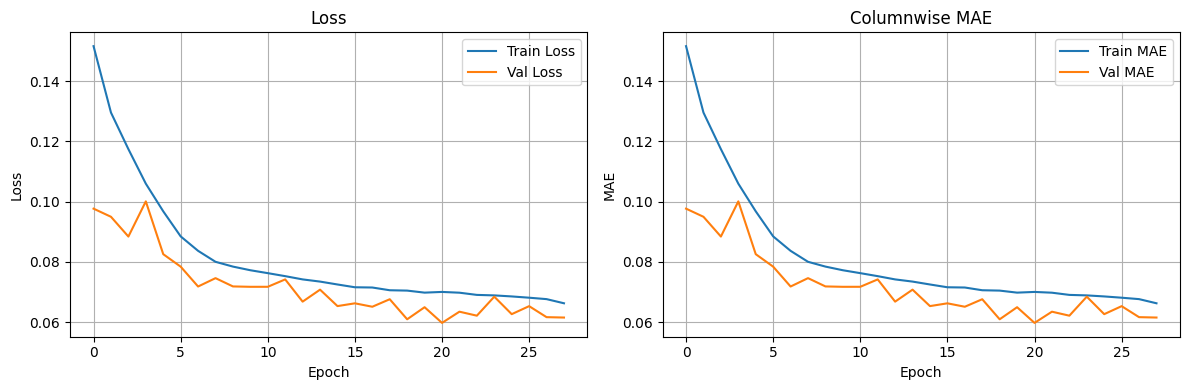

In [ ]:
draw_plots(history2)

In [ ]:
class SmallCNN(nn.Module):
    def __init__(self, num_keypoints=18):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2),  # 112x112

            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2),  # 56x56

            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.MaxPool2d(2),  # 28x28

            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.AdaptiveAvgPool2d((7, 7))
        )

        self.regressor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256*7*7, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_keypoints)
        )

    def forward(self, x):
        return self.regressor(self.features(x))


In [ ]:
model24 = SmallCNN().to(device)
#criterion = nn.MSELoss()
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model24.parameters(), lr=1e-3)
num_epochs = 50

In [ ]:
%%time
history24 = train_model(model24, dataloaders, optimizer, num_epochs, criterion, device, patience_early_stop=7, path="best_model2_4.pth")

Epoch 1: Train Loss: 0.2514 | Val Loss: 0.0970
Epoch 2: Train Loss: 0.1314 | Val Loss: 0.0936
Epoch 3: Train Loss: 0.1211 | Val Loss: 0.1027
Epoch 4: Train Loss: 0.1103 | Val Loss: 0.0859
Epoch 5: Train Loss: 0.1042 | Val Loss: 0.0889
Epoch 6: Train Loss: 0.0975 | Val Loss: 0.0781
Epoch 7: Train Loss: 0.0914 | Val Loss: 0.0756
Epoch 8: Train Loss: 0.0860 | Val Loss: 0.0751
Epoch 9: Train Loss: 0.0801 | Val Loss: 0.0742
Epoch 10: Train Loss: 0.0772 | Val Loss: 0.0670
Epoch 11: Train Loss: 0.0743 | Val Loss: 0.0680
Epoch 12: Train Loss: 0.0725 | Val Loss: 0.0638
Epoch 13: Train Loss: 0.0708 | Val Loss: 0.0665
Epoch 14: Train Loss: 0.0690 | Val Loss: 0.0664
Epoch 15: Train Loss: 0.0679 | Val Loss: 0.0639
Epoch 16: Train Loss: 0.0672 | Val Loss: 0.0633
Epoch 17: Train Loss: 0.0656 | Val Loss: 0.0576
Epoch 18: Train Loss: 0.0649 | Val Loss: 0.0605
Epoch 19: Train Loss: 0.0643 | Val Loss: 0.0604
Epoch 20: Train Loss: 0.0635 | Val Loss: 0.0568
Epoch 21: Train Loss: 0.0627 | Val Loss: 0.0580
E

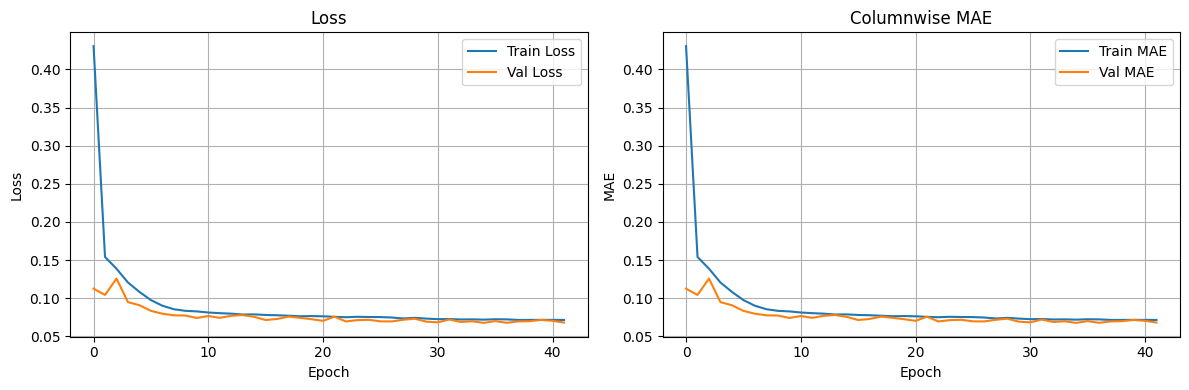

In [ ]:
draw_plots(history2)

In [ ]:
class SmallCNN2(nn.Module):
    def __init__(self, num_keypoints=18):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2),  # 112x112

            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2),  # 56x56

            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.MaxPool2d(2),  # 28x28

            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.AdaptiveAvgPool2d((7, 7))
        )

        self.regressor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256*7*7, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_keypoints)
        )

    def forward(self, x):
        return self.regressor(self.features(x))


In [ ]:
model2d = SmallCNN2().to(device)
#criterion = nn.MSELoss()
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model2d.parameters(), lr=1e-3)
num_epochs = 50

In [ ]:
%%time
history24 = train_model(model2d, dataloaders, optimizer, num_epochs, criterion, device, patience_early_stop=7, path="best_model2_d.pth")

Epoch 1: Train Loss: 0.1951 | Val Loss: 0.0992
Epoch 2: Train Loss: 0.1065 | Val Loss: 0.0857
Epoch 3: Train Loss: 0.0953 | Val Loss: 0.0828
Epoch 4: Train Loss: 0.0898 | Val Loss: 0.0775
Epoch 5: Train Loss: 0.0846 | Val Loss: 0.0707
Epoch 6: Train Loss: 0.0833 | Val Loss: 0.0702
Epoch 7: Train Loss: 0.0781 | Val Loss: 0.0683
Epoch 8: Train Loss: 0.0764 | Val Loss: 0.0648
Epoch 9: Train Loss: 0.0735 | Val Loss: 0.0653
Epoch 10: Train Loss: 0.0691 | Val Loss: 0.0610
Epoch 11: Train Loss: 0.0668 | Val Loss: 0.0599
Epoch 12: Train Loss: 0.0642 | Val Loss: 0.0690
Epoch 13: Train Loss: 0.0626 | Val Loss: 0.0639
Epoch 14: Train Loss: 0.0609 | Val Loss: 0.0612
Epoch 15: Train Loss: 0.0596 | Val Loss: 0.0553
Epoch 16: Train Loss: 0.0567 | Val Loss: 0.0603
Epoch 17: Train Loss: 0.0552 | Val Loss: 0.0542
Epoch 18: Train Loss: 0.0551 | Val Loss: 0.0544
Epoch 19: Train Loss: 0.0526 | Val Loss: 0.0538
Epoch 20: Train Loss: 0.0513 | Val Loss: 0.0517
Epoch 21: Train Loss: 0.0506 | Val Loss: 0.0540
E

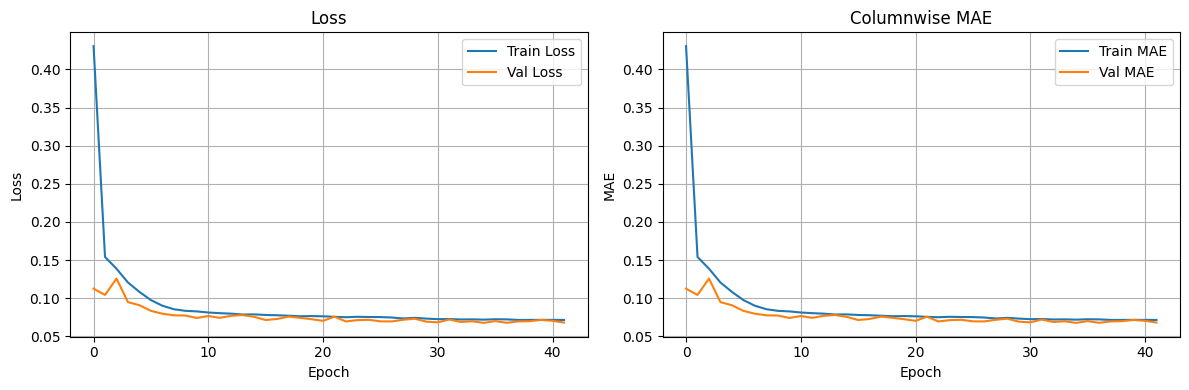

In [ ]:
draw_plots(history2)

#### Эксперимент 3

In [ ]:
class ResCNN(nn.Module):
    def __init__(self, num_keypoints: int = 18, base: int = 32, drop2d: float = 0.02, dropout: float = 0.2):
        super().__init__()
        self.base = base

        # Stem: 5 каналов -> 32
        self.stem = nn.Sequential(
            nn.Conv2d(5, base, 3, padding=1, bias=False),
            nn.BatchNorm2d(base),
            nn.SiLU(inplace=True),
        )

        # Блоков делаем поровну: [2, 2, 2, 2]
        self.stage1 = nn.Sequential(
            ResBlock(base, base, stride=1, drop2d=drop2d),
            ResBlock(base, base, stride=1, drop2d=drop2d),
        )
        self.stage2 = nn.Sequential(
            ResBlock(base, base*2, stride=2, drop2d=drop2d),
            ResBlock(base*2, base*2, stride=1, drop2d=drop2d),
        )
        self.stage3 = nn.Sequential(
            ResBlock(base*2, base*4, stride=2, drop2d=drop2d),
            ResBlock(base*4, base*4, stride=1, drop2d=drop2d), # Убрали лишний блок
        )
        self.stage4 = nn.Sequential(
            ResBlock(base*4, base*8, stride=2, drop2d=drop2d),
            ResBlock(base*8, base*8, stride=1, drop2d=drop2d),
        )

        # Сжатие: base*8 (256 каналов при base=32)
        self.compress = nn.Sequential(
            nn.Conv2d(base*8, base*4, kernel_size=1, bias=False),
            nn.BatchNorm2d(base*4),
            nn.SiLU(inplace=True),
        )

        self.pool = nn.AdaptiveAvgPool2d((4, 4))

        # Упрощенная голова: меньше слоев = меньше оверфита
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(base*4*4*4, 512), # 128*4*4 = 2048 -> 512
            nn.SiLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(512, num_keypoints) # Сразу выход
        )

    def _add_coord_channels(self, x):
        b, _, h, w = x.shape
        ys = torch.linspace(-1, 1, steps=h, device=x.device).view(1, 1, h, 1).expand(b, 1, h, w)
        xs = torch.linspace(-1, 1, steps=w, device=x.device).view(1, 1, 1, w).expand(b, 1, h, w)
        return torch.cat([x, xs, ys], dim=1)

    def forward(self, x):
        x = self._add_coord_channels(x)
        x = self.stem(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.compress(x)
        x = self.pool(x)
        return self.head(x)

In [ ]:
model3 = ResCNN().to(device)
#criterion = nn.MSELoss()
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model2d.parameters(), lr=1e-3)
num_epochs = 50

In [ ]:
def postprocess_preds(preds, original_widths, original_heights, target_size=224):
    """
    preds: тензор (N, 18) в диапазоне [0, 1]
    returns: тензор с реальными пикселями
    """
    rescaled_preds = preds.copy()
    for i in range(len(preds)):
        w, h = original_widths[i], original_heights[i]
        scale = target_size / max(h, w)
        nw, nh = int(w * scale), int(h * scale)
        pad_x, pad_y = (target_size - nw) // 2, (target_size - nh) // 2

        # Сначала из [0, 1] в [0, 224]
        rescaled_preds[i] *= target_size
        # Вычитаем паддинг и делим на коэффициент масштаба
        rescaled_preds[i, 0::2] = (rescaled_preds[i, 0::2] - pad_x) / scale
        rescaled_preds[i, 1::2] = (rescaled_preds[i, 1::2] - pad_y) / scale

    return rescaled_preds

### Evaluation  (оценка качества модели)

В этом разделе проводите оценку качества вашей итоговой модели (с помощью prediction function из раздела выше).

добавить преобразования для теста

In [ ]:
# model evaluation

### Conclusion (Выводы)

В этом разделе описываете полученные результаты и проводите анализ выполненной работы.
Что получилось / не получилось и почему?